# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [14]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Time series analysis

Load the data from "Price of Weed".

In [15]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


The following function takes a DataFrame of transactions and compute daily averages.

In [16]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

The following function returns a map from quality name to a DataFrame of daily averages.

In [17]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

`dailies` is the map from quality name to DataFrame.

In [18]:
dailies = GroupByQualityAndDay(transactions)
dailies['high'].head()

,ppg,date,years
date,,,
2010-09-02,13.384186,2010-09-02,0.000000
2010-09-03,14.459588,2010-09-03,0.002738
2010-09-04,14.923333,2010-09-04,0.005476
2010-09-05,16.667500,2010-09-05,0.008214
2010-09-06,15.537500,2010-09-06,0.010952


The following plots the daily average price for each quality.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


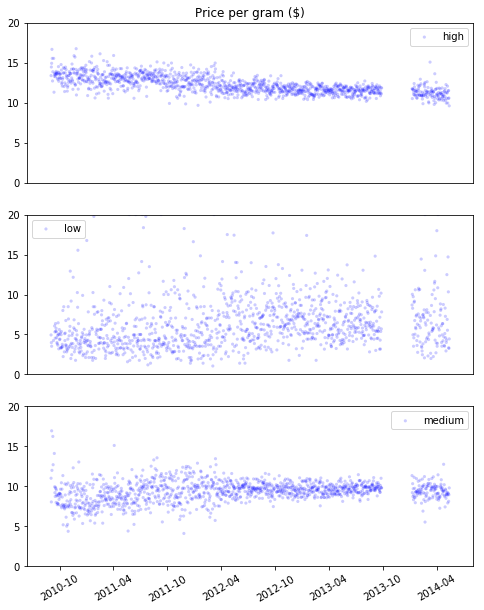

In [19]:
import matplotlib.pyplot as plt

thinkplot.PrePlot(rows=3)
for i, (name, daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'Price per gram ($)' if i == 0 else ''
    thinkplot.Config(ylim=[0, 20], title=title)
    thinkplot.Scatter(daily.ppg, s=10, label=name)
    if i == 2: 
        plt.xticks(rotation=30)
        thinkplot.Config()
    else:
        thinkplot.Config(xticks=[])

We can use `statsmodels` to run a linear model of price as a function of time.

In [20]:
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

Here's what the results look like.

In [21]:
from IPython.display import display

for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print(name)
    display(results.summary())

high


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Thu, 12 Jul 2018   Prob (F-statistic):          3.69e-160
Time:                        18:47:03   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.080      0.000      13.361      13.539
years         -0.7082      0.023    -31.460      0.000      -0.752      -0.664
==============================================================================
Omnibus:                       56.254   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.992
Skew:                           0.252   Prob(JB):                     9.76e-29
Kurtosis:                       4.497   Cond. No.                         4.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

low


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     35.90
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           2.76e-09
Time:                        18:47:03   Log-Likelihood:                -3091.3
No. Observations:                1179   AIC:                             6187.
Df Residuals:                    1177   BIC:                             6197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3616      0.194     27.671      0.000       4.981       5.742
years          0.5683      0.095      5.991      0.000       0.382       0.754
==============================================================================
Omnibus:                      649.338   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6347.614
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      13.329   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

medium


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     64.92
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           1.82e-15
Time:                        18:47:03   Log-Likelihood:                -2053.9
No. Observations:                1238   AIC:                             4112.
Df Residuals:                    1236   BIC:                             4122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8791      0.071    125.043      0.000       8.740       9.018
years          0.2832      0.035      8.057      0.000       0.214       0.352
==============================================================================
Omnibus:                      133.025   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.863
Skew:                           0.385   Prob(JB):                    1.02e-137
Kurtosis:                       6.411   Cond. No.                         4.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's plot the fitted model with the data.

In [22]:
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

The following function plots the original data and the fitted curve.

In [23]:
def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.
    
    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(title='Fitted values',
                     xlabel='Years',
                     xlim=[-0.1, 3.8],
                     ylabel='Price per gram ($)')

Here are results for the high quality category:

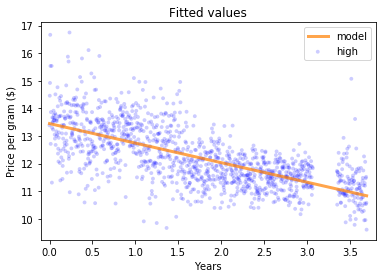

In [24]:
name = 'high'
daily = dailies[name]

PlotLinearModel(daily, name)

## Moving averages

As a simple example, I'll show the rolling average of the numbers from 1 to 10.

In [25]:
series = np.arange(10)

With a "window" of size 3, we get the average of the previous 3 elements, or nan when there are fewer than 3.

In [26]:
#series.rolling(3).mean()

The following function plots the rolling mean.

In [27]:
def PlotRollingMean(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed['ppg'].rolling(30).mean()
    thinkplot.Plot(roll_mean, label='rolling mean', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

Here's what it looks like for the high quality category.

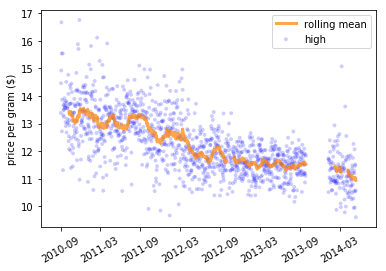

In [28]:
PlotRollingMean(daily, name)

The exponentially-weighted moving average gives more weight to more recent points.

In [29]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed['ppg'].ewm(span=30).mean()
    thinkplot.Plot(roll_mean, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

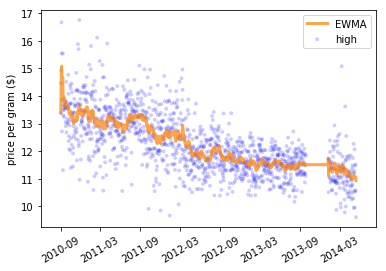

In [30]:
PlotEWMA(daily, name)

We can use resampling to generate missing values with the right amount of noise.

In [31]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = reindexed['ppg'].ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

In [32]:
def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='Price per gram ($)')

Here's what the EWMA model looks like with missing values filled.

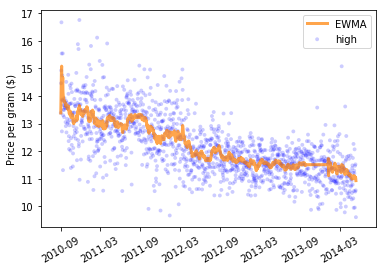

In [33]:
PlotFilled(daily, name)

## Serial correlation

The following function computes serial correlation with the given lag.

In [34]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

Before computing correlations, we'll fill missing values.

In [35]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

Here are the serial correlations for raw price data.

In [36]:
for name, filled in filled_dailies.items():      
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)

high 0.48564481196505166
low 0.12282918071160652
medium 0.16393873438793896


It's not surprising that there are correlations between consecutive days, because there are obvious trends in the data.

It is more interested to see whether there are still correlations after we subtract away the trends.

In [37]:
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)

high -0.007725024849122017
low 0.04989683555857519
medium -0.022905168602909344


Even if the correlations between consecutive days are weak, there might be correlations across intervals of one week, one month, or one year.

In [38]:
rows = []
for lag in [1, 7, 30, 365]:
    print(lag, end='\t')
    for name, filled in filled_dailies.items():            
        corr = SerialCorr(filled.resid, lag)
        print('%.2g' % corr, end='\t')
    print()

1	-0.0077	0.05	-0.023	
7	0.00025	-0.039	-0.051	
30	0.005	-0.025	-0.0061	
365	0.039	0.037	0.012	


The strongest correlation is a weekly cycle in the medium quality category.

## Autocorrelation

The autocorrelation function is the serial correlation computed for all lags.

We can use it to replicate the results from the previous section.

In [39]:
import statsmodels.tsa.stattools as smtsa

filled = filled_dailies['high']
acf = smtsa.acf(filled.resid, nlags=365, unbiased=True)
print('%0.2g, %.2g, %0.2g, %0.2g, %0.2g' % 
      (acf[0], acf[1], acf[7], acf[30], acf[365]))

1, -0.0077, 0.00025, 0.005, 0.037


To get a sense of how much autocorrelation we should expect by chance, we can resample the data (which eliminates any actual autocorrelation) and compute the ACF.

In [40]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')

The following function plots the actual autocorrelation for lags up to 40 days.

The flag `add_weekly` indicates whether we should add a simulated weekly cycle.

In [41]:
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

To show what a strong weekly cycle would look like, we have the option of adding a price increase of 1-2 dollars on Friday and Saturdays.

In [42]:
def AddWeeklySeasonality(daily):
    """Adds a weekly pattern.

    daily: DataFrame of daily prices

    returns: new DataFrame of daily prices
    """
    fri_or_sat = (daily.index.dayofweek==4) | (daily.index.dayofweek==5)
    fake = daily.copy()
    fake.ppg.loc[fri_or_sat] += np.random.uniform(0, 2, fri_or_sat.sum())
    return fake

Here's what the real ACFs look like.  The gray regions indicate the levels we expect by chance.

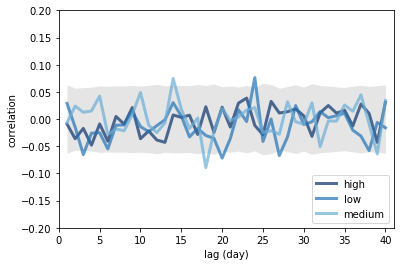

In [43]:
axis = [0, 41, -0.2, 0.2]

PlotAutoCorrelation(dailies, add_weekly=False)
thinkplot.Config(axis=axis, 
                     loc='lower right',
                     ylabel='correlation',
                     xlabel='lag (day)')

Here's what it would look like if there were a weekly cycle.

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


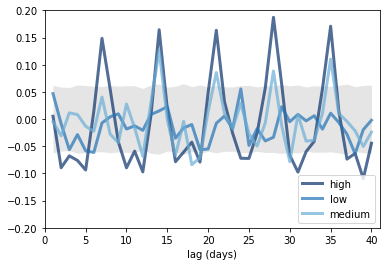

In [44]:
PlotAutoCorrelation(dailies, add_weekly=True)
thinkplot.Config(axis=axis,
                 loc='lower right',
                 xlabel='lag (days)')

## Prediction

The simplest way to generate predictions is to use `statsmodels` to fit a model to the data, then use the `predict` method from the results.

In [45]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

In [46]:
def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color='#ff7f00')
    xlim = years[0]-0.1, years[-1]+0.1
    thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)',
                 loc='upper right')

Here's what the prediction looks like for the high quality category, using the linear model.

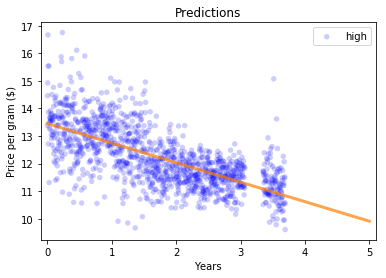

In [47]:
name = 'high'
daily = dailies[name]

_, results = RunLinearModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

When we generate predictions, we want to quatify the uncertainty in the prediction.  We can do that by resampling.  The following function fits a model to the data, computes residuals, then resamples from the residuals to general fake datasets.  It fits the same model to each fake dataset and returns a list of results.

In [48]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

To generate predictions, we take the list of results fitted to resampled data.  For each model, we use the `predict` method to generate predictions, and return a sequence of predictions.

If `add_resid` is true, we add resampled residuals to the predicted values, which generates predictions that include predictive uncertainty (due to random noise) as well as modeling uncertainty (due to random sampling).

In [49]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

To visualize predictions, I show a darker region that quantifies modeling uncertainty and a lighter region that quantifies predictive uncertainty.

In [50]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

Here are the results for the high quality category.

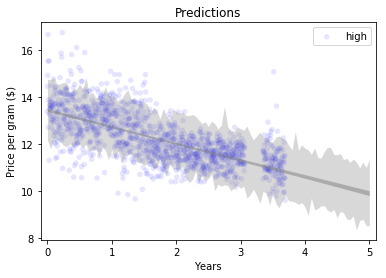

In [51]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

But there is one more source of uncertainty: how much past data should we use to build the model?

The following function generates a sequence of models based on different amounts of past data.

In [52]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

And this function plots the results.

In [53]:
def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')

Here's what the high quality category looks like if we take into account uncertainty about how much past data to use.

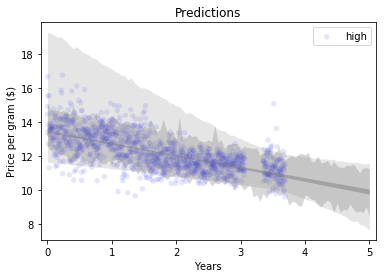

In [54]:
name = 'high'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)')

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [55]:
# Solution goes here
def RunQuadraticModel(daily):
    daily['years2'] = daily['years']**2
    model = smf.ols('ppg ~ years + years2', daily)
    results = model.fit()
    return model, results

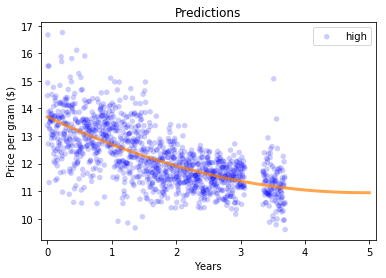

In [56]:
# Solution goes here
name = 'high'
daily = filled_dailies[name]

_, results = RunQuadraticModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

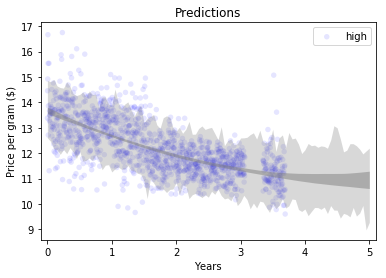

In [57]:
# Solution goes here
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


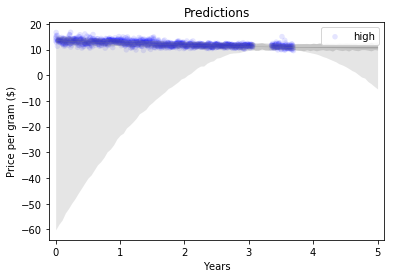

In [58]:
# Solution goes here
name = 'high'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years, func=RunQuadraticModel)
PlotPredictions(daily, years, func=RunQuadraticModel)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)')

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [59]:
# Solution goes here
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        return SerialCorr(series, lag)
    
    def RunModel(self):
        series, lag = self.data
        resampled_data = series.sample(len(series), replace=False)
        return resampled_data, lag

In [60]:
# Solution goes here
for name, filled in filled_dailies.items():
    serCorr = SerialCorrelationTest((filled.ppg, 1))
    p_value = serCorr.PValue()
    print(name, p_value)

high 0.0
low 0.0
medium 0.0


In [61]:
# Solution goes here
for name, filled in filled_dailies.items():
    serCorr = SerialCorrelationTest((filled.resid, 1))
    p_value = serCorr.PValue()
    print(name, p_value)

high 0.601
low 0.034
medium 0.78


In [62]:
# Solution goes here
for name, filled in filled_dailies.items():
    _, results = RunQuadraticModel(filled)
    serCorr = SerialCorrelationTest((results.resid, 1))
    p_value = serCorr.PValue()
    print(name, p_value)

high 0.023
low 0.004
medium 0.001


**Worked example:** There are several ways to extend the EWMA model to generate predictions. One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, `inter`.

2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, `slope`.

3. To predict values at future times, compute `inter + slope * dt`, where `dt` is the difference between the time of the prediction and the time of the last observation.


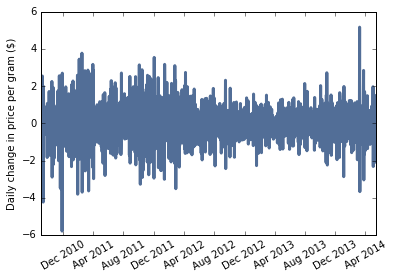

In [50]:
name = 'high'
daily = dailies[name]

filled = FillMissing(daily)
diffs = filled.ppg.diff()

thinkplot.plot(diffs)
plt.xticks(rotation=30)
thinkplot.Config(ylabel='Daily change in price per gram ($)')

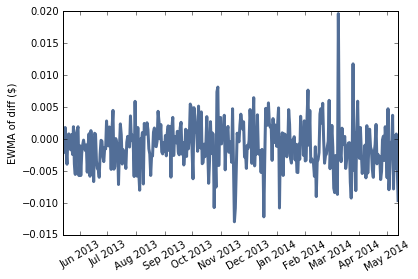

In [51]:
filled['slope'] = pd.ewma(diffs, span=365)
thinkplot.plot(filled.slope[-365:])
plt.xticks(rotation=30)
thinkplot.Config(ylabel='EWMA of diff ($)')

In [52]:
# extract the last inter and the mean of the last 30 slopes
start = filled.index[-1]
inter = filled.ewma[-1]
slope = filled.slope[-30:].mean()

start, inter, slope

(Timestamp('2014-05-13 00:00:00', offset='D'),
 10.929518765455491,
 -0.0025675148856640546)

In [53]:
# reindex the DataFrame, adding a year to the end
dates = pd.date_range(filled.index.min(), 
                      filled.index.max() + np.timedelta64(365, 'D'))
predicted = filled.reindex(dates)

In [54]:
# generate predicted values and add them to the end
predicted['date'] = predicted.index
one_day = np.timedelta64(1, 'D')
predicted['days'] = (predicted.date - start) / one_day
predict = inter + slope * predicted.days
predicted.ewma.fillna(predict, inplace=True)

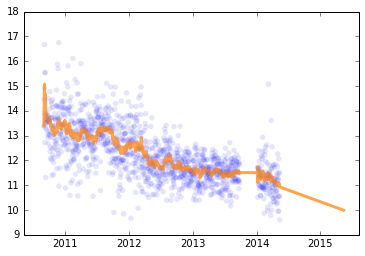

In [55]:
# plot the actual values and predictions
thinkplot.Scatter(daily.ppg, alpha=0.1, label=name)
thinkplot.Plot(predicted.ewma, color='#ff7f00')

As an exercise, run this analysis again for the other quality categories.